# Swin Transformer

Samples:  5040 630 631
Batch:  315 40 40
Batch shapes: torch.Size([16, 1, 224, 224]), torch.Size([16, 1, 224, 224])


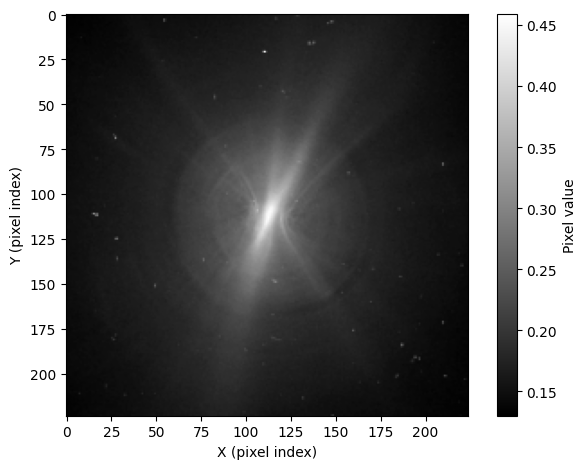

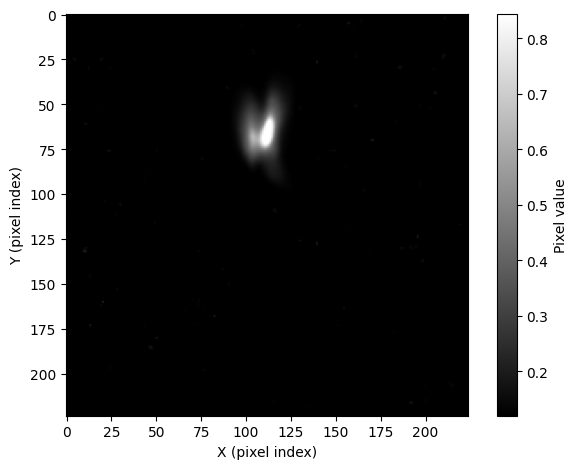

Detected framework: PyTorch
Framework:           PyTorch
Model:               SwinUNet
Device / dtype:      unavailable / N/A
Parameters:          26,667,853 total
                     26,667,853 trainable
                     0 non-trainable
Size:                103.52 MB
Sub-modules:         222


In [ ]:
# pip install xflow-py
from xflow import ConfigManager, FileProvider, PyTorchPipeline, show_model_info
from xflow.data import build_transforms_from_config
from xflow.utils import load_validated_config, plot_image

from config_utils import load_config

# Configuration
config_manager = ConfigManager(load_config("SwinT.yaml"))
config = config_manager.get()
config_manager.add_files(config["extra_files"])

# ==================== 
# Prepare Dataset
# ====================
provider = FileProvider(config["paths"]["dataset"]).subsample(fraction=config["data"]["subsample_fraction"], seed=config["seed"]) #
train_provider, temp_provider = provider.split(ratio=config["data"]["train_val_split"], seed=config["seed"])
val_provider, test_provider = temp_provider.split(ratio=config["data"]["val_test_split"], seed=config["seed"])
transforms = build_transforms_from_config(config["data"]["transforms"]["torch"])

def make_dataset(provider):
    return PyTorchPipeline(provider, transforms).to_memory_dataset(config["data"]["dataset_ops"])

train_dataset = make_dataset(train_provider)
val_dataset = make_dataset(val_provider)
test_dataset = make_dataset(test_provider)

print("Samples: ",len(train_provider),len(val_provider),len(test_provider))
print("Batch: ",len(train_dataset),len(val_dataset),len(test_dataset))

for left_parts, right_parts in test_dataset:
    # batch will be a tuple: (right_halves, left_halves) due to split_width
    print(f"Batch shapes: {left_parts.shape}, {right_parts.shape}")
    plot_image(left_parts[0])
    plot_image(right_parts[0])
    break

# ==================== 
# Construct Model
# ====================
import torch
from SwinT import SwinUNet

model = SwinUNet(
    in_chans=config["model"]["in_chans"],
    out_chans=config["model"]["out_chans"],
    )  # 224x224x1 -> 224x224x1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
show_model_info(model)

## Training

In [2]:
from utils import make_beam_param_metric
from functools import partial

import xflow.extensions.physics
from xflow.trainers import TorchTrainer, build_callbacks_from_config
from xflow.extensions.physics.beam import extract_beam_parameters

# 1) device/model/optim/loss

# Option A: generic image intensity reconstruction
criterion = torch.nn.L1Loss()  # or Charbonnier.  torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=config['training']['learning_rate'], 
                             weight_decay=config['training']['weight_decay'])

# 2) callbacks (unchanged) + any custom wiring
callbacks = build_callbacks_from_config(
    config=config["callbacks"],
    framework=config["framework"],  
)
callbacks[-1].set_dataset(test_dataset)  # keep dataset closure

# Extract beam parameters
extract_beam_parameters_dict = partial(extract_beam_parameters, as_array=False)
beam_param_metric = make_beam_param_metric(extract_beam_parameters_dict)

# 3) run training
trainer = TorchTrainer(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    callbacks=callbacks,
    output_dir=config["paths"]["output"],
    data_pipeline=train_dataset,
    val_metrics=[beam_param_metric]
)

history = trainer.fit(
    train_loader=train_dataset, 
    val_loader=val_dataset,
    epochs=config['training']['epochs'],
)

# 4) persist
trainer.save_history(f"{config['paths']['output']}/history.json")
trainer.save_model(config["paths"]["output"])  # uses model.save_model(...) if available
config_manager.save(output_dir=config["paths"]["output"], config_filename=config["name"])

Starting Training
Total epochs: 100

Epoch 1/100 - 315 batches
input image max pixel: 0.4805, ground truth image max pixel: 0.8444, reconstructed image max pixel: 1.2135
[==============================] 315/315 (100.0%) - ETA: 0s - train_loss: 0.0295 - val_loss: 0.0146                    
Epoch 1 completed in 2404.41s - train_loss: 0.0295 - val_loss: 0.0146

Epoch 2/100 - 315 batches
input image max pixel: 0.4089, ground truth image max pixel: 0.8444, reconstructed image max pixel: 0.2456
[==============================] 315/315 (100.0%) - ETA: 0s - train_loss: 0.0135 - val_loss: 0.0122                    
Epoch 2 completed in 2406.99s - train_loss: 0.0135 - val_loss: 0.0122

Epoch 3/100 - 315 batches
input image max pixel: 0.5770, ground truth image max pixel: 0.5910, reconstructed image max pixel: 0.2356
[==============================] 315/315 (100.0%) - ETA: 0s - train_loss: 0.0122 - val_loss: 0.0120                    
Epoch 3 completed in 2367.25s - train_loss: 0.0122 - val_loss:

KeyboardInterrupt: 

## Evaluation